In [37]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [38]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [39]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [40]:
gain = 5 / 3
fan_in = block_size * embedding_size
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = (
    torch.randn((block_size * embedding_size, hidden_size), generator=g)
    * gain
    / (fan_in**0.5)
)
# b1 = torch.randn(hidden_size, generator=g) * 0.01
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [41]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())

0 / 200000, loss: 3.3077244758605957
10000 / 200000, loss: 2.5955028533935547
20000 / 200000, loss: 2.411327600479126
30000 / 200000, loss: 2.325739622116089
40000 / 200000, loss: 2.079864501953125
50000 / 200000, loss: 2.207869052886963
60000 / 200000, loss: 2.3166422843933105
70000 / 200000, loss: 2.162741184234619
80000 / 200000, loss: 2.2557361125946045
90000 / 200000, loss: 1.8301655054092407
100000 / 200000, loss: 2.078809976577759
110000 / 200000, loss: 1.9613778591156006
120000 / 200000, loss: 2.1667680740356445
130000 / 200000, loss: 1.9555691480636597
140000 / 200000, loss: 2.0562069416046143
150000 / 200000, loss: 1.919661283493042
160000 / 200000, loss: 1.9060178995132446
170000 / 200000, loss: 1.7950860261917114
180000 / 200000, loss: 1.850508689880371
190000 / 200000, loss: 1.5848298072814941


(array([422., 236., 201., 169., 135., 124., 103., 119.,  96., 100.,  99.,
         85.,  94.,  78.,  99.,  98.,  90.,  98.,  82.,  94.,  87., 113.,
        119., 112., 137., 131., 124., 101., 105.,  94.,  80.,  96., 104.,
         96.,  82.,  75.,  90.,  96.,  93., 101.,  91.,  98., 128., 120.,
        122., 133., 153., 192., 241., 464.]),
 array([-9.99901116e-01, -9.59904083e-01, -9.19907050e-01, -8.79910017e-01,
        -8.39912984e-01, -7.99915951e-01, -7.59918919e-01, -7.19921886e-01,
        -6.79924853e-01, -6.39927820e-01, -5.99930787e-01, -5.59933754e-01,
        -5.19936721e-01, -4.79939688e-01, -4.39942656e-01, -3.99945623e-01,
        -3.59948590e-01, -3.19951557e-01, -2.79954524e-01, -2.39957491e-01,
        -1.99960458e-01, -1.59963425e-01, -1.19966393e-01, -7.99693596e-02,
        -3.99723268e-02,  2.47061253e-05,  4.00217390e-02,  8.00187719e-02,
         1.20015805e-01,  1.60012838e-01,  2.00009871e-01,  2.40006903e-01,
         2.80003936e-01,  3.20000969e-01,  3.59998

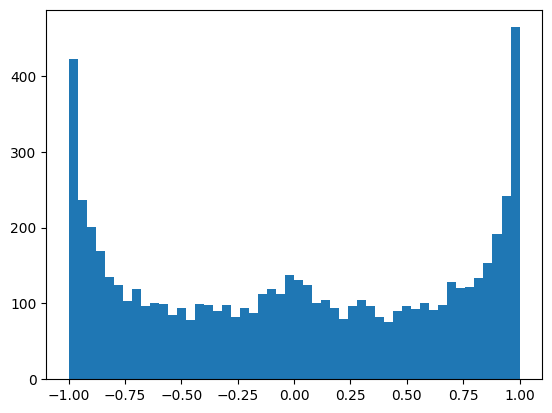

In [42]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  2.,   3.,   1.,   4.,   6.,   7.,  14.,  17.,  29.,  23.,  38.,
         52.,  71.,  91., 100., 130., 172., 218., 224., 273., 303., 339.,
        433., 535., 597., 445., 348., 315., 300., 243., 194., 178., 141.,
        127., 114.,  72.,  51.,  47.,  39.,  31.,  25.,  21.,   6.,   9.,
          5.,   1.,   2.,   1.,   1.,   2.]),
 array([-4.95729637, -4.75207995, -4.54686354, -4.34164712, -4.1364307 ,
        -3.93121428, -3.72599787, -3.52078145, -3.31556503, -3.11034862,
        -2.9051322 , -2.69991578, -2.49469936, -2.28948295, -2.08426653,
        -1.87905011, -1.67383369, -1.46861728, -1.26340086, -1.05818444,
        -0.85296803, -0.64775161, -0.44253519, -0.23731877, -0.03210236,
         0.17311406,  0.37833048,  0.5835469 ,  0.78876331,  0.99397973,
         1.19919615,  1.40441257,  1.60962898,  1.8148454 ,  2.02006182,
         2.22527823,  2.43049465,  2.63571107,  2.84092749,  3.0461439 ,
         3.25136032,  3.45657674,  3.66179316,  3.86700957,  4.07222599,
 

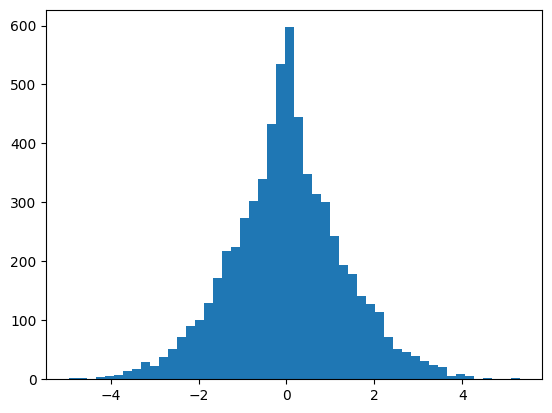

In [43]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

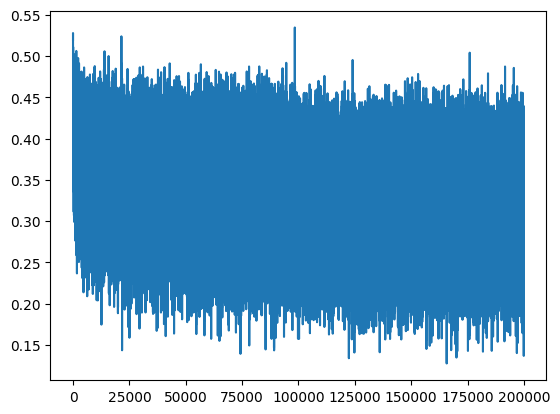

In [44]:
plt.plot(lossi)

In [45]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0693938732147217
val 2.11151385307312


In [46]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

pristhqlieribellesnatonlbyannozttheldyn.
fraydanne.
grammalbangelistraliyanna.
alleevorgwhellyssader.
frett.
dastuldm.
ssfaniyh.
hengrkfarzhi.
dylnailfarustopptardrix.
harrickessaphnibhdojabdrix.
trix.
gracishmuwgishckrahxthelashfaallynkoldutchia.
evantwhnurdemctorinck.
grachabbrtzlamlamder.
qubhrandrustanzleborthasingt.
cyldenck.
brylandrissadevangelfarlynky.
gradn.
brissambrad.
theldda.


In [47]:
# SUMMARY + PYTORCHIFYING -----------

In [48]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn(fan_in, fan_out, generator=g) * gain / (fan_in**0.5)
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * xmean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []


vocab_size = len(itos)
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [60]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    # construct a batch
    ix = torch.randint(0, len(X_train), (batch_size,), generator=g)
    Xbatch, Ybatch = X_train[ix], y_train[ix]
    # forward
    emb = C[Xbatch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ybatch)
    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [
                ((lr * p.grad).std() / p.data.std()).log10().item()
                for p in parameters
            ]
        )
    if i > 1000:
        break

      0/200000, loss: 2.059263229370117


layer 2 (      Tanh): mean -0.04, std 0.70, saturated: 14.31%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 15.69%
layer 8 (      Tanh): mean -0.00, std 0.74, saturated: 16.97%
layer 11 (      Tanh): mean +0.01, std 0.76, saturated: 16.47%
layer 14 (      Tanh): mean +0.01, std 0.78, saturated: 19.66%


Text(0.5, 1.0, 'Activation distribution')

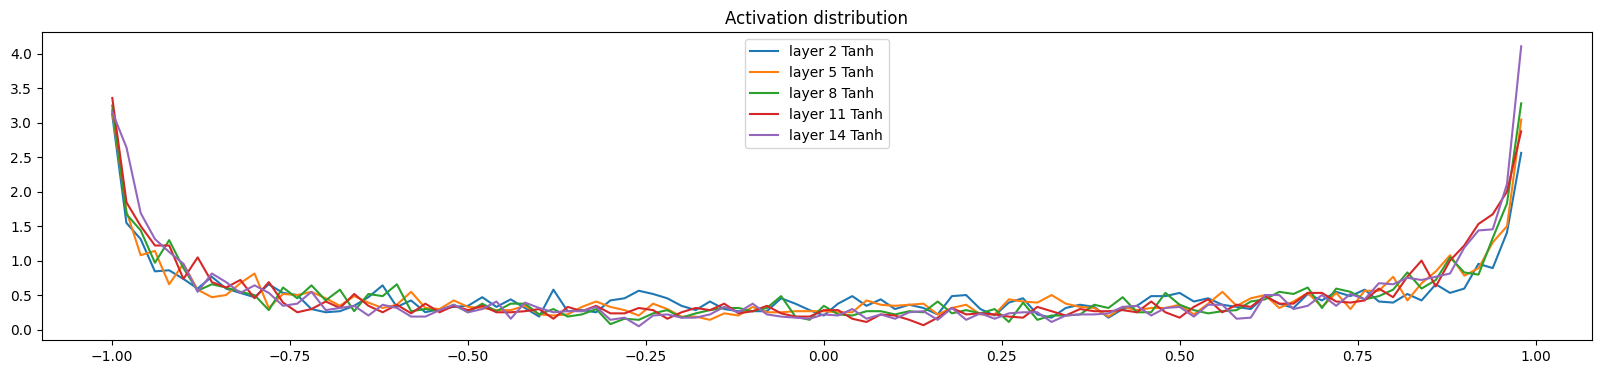

In [61]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activation distribution")

layer 2 (      Tanh): mean -0.000000, std 3.752165e-03
layer 5 (      Tanh): mean -0.000000, std 3.418838e-03
layer 8 (      Tanh): mean -0.000000, std 3.219302e-03
layer 11 (      Tanh): mean +0.000000, std 2.953358e-03
layer 14 (      Tanh): mean +0.000000, std 3.098386e-03


Text(0.5, 1.0, 'gradient distribution')

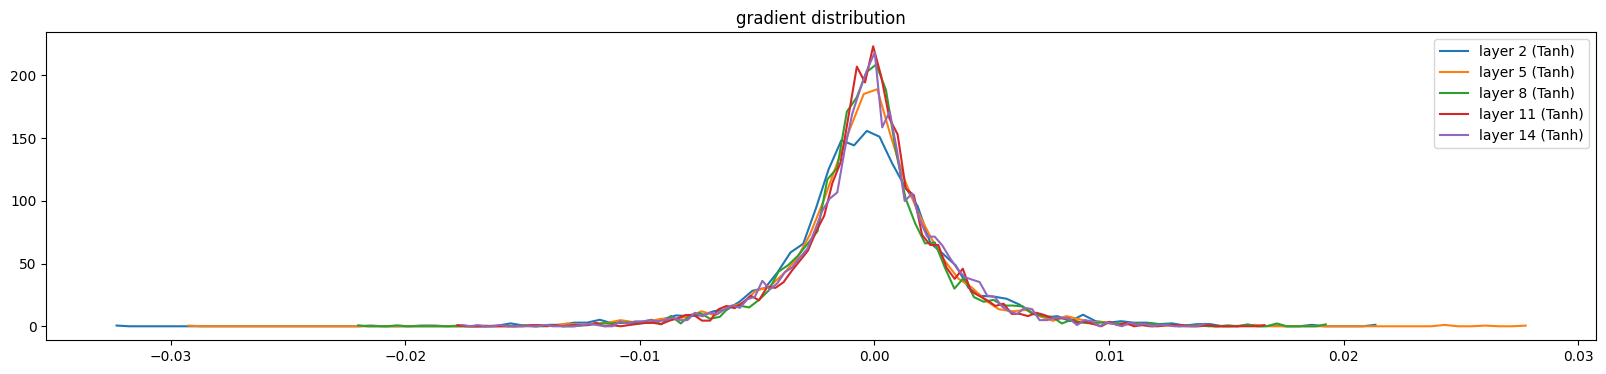

In [62]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        if t is not None:
            print(
                "layer %d (%10s): mean %+f, std %e"
                % (i, layer.__class__.__name__, t.mean(), t.std())
            )
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__})")
        else:
            print(f"layer {i} ({layer.__class__.__name__}) has no gradient")
plt.legend(legends)
plt.title("gradient distribution")

weight:        (27, 10) | mean:   0.000000 | std: 1.415884e-02 | grad:data ratio: 1.295512e-02
weight:       (30, 100) | mean:  -0.000130 | std: 8.748185e-03 | grad:data ratio: 2.120430e-02
weight:      (100, 100) | mean:   0.000032 | std: 5.415075e-03 | grad:data ratio: 2.183496e-02
weight:      (100, 100) | mean:  -0.000017 | std: 5.068364e-03 | grad:data ratio: 2.079951e-02
weight:      (100, 100) | mean:   0.000036 | std: 4.642994e-03 | grad:data ratio: 1.957232e-02
weight:      (100, 100) | mean:   0.000017 | std: 4.132651e-03 | grad:data ratio: 1.794813e-02
weight:       (100, 27) | mean:  -0.000043 | std: 6.635344e-03 | grad:data ratio: 1.999319e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

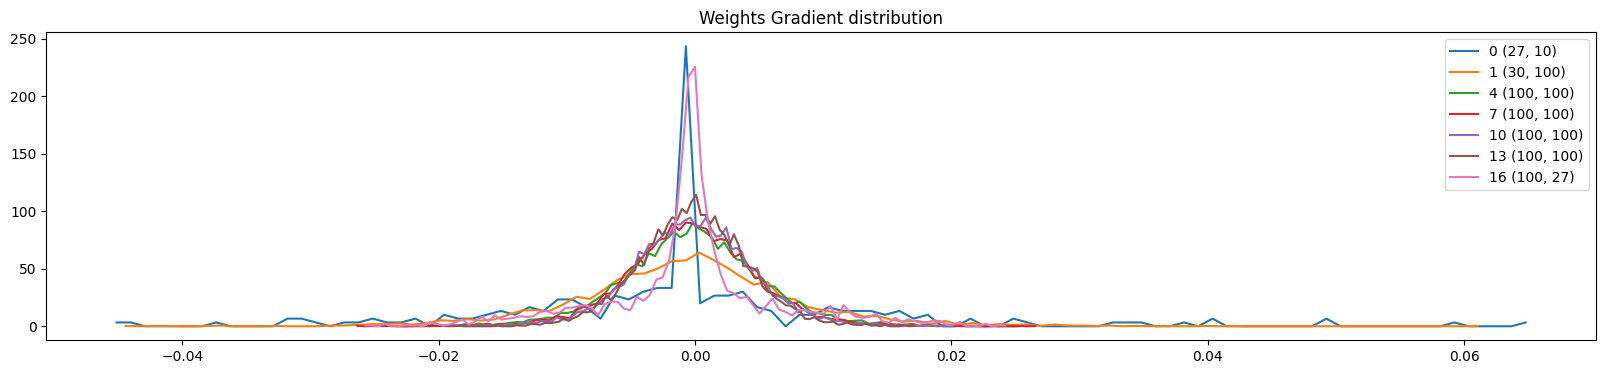

In [81]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"weight: {str(tuple(p.shape)):>15} | mean: {t.mean():>10.6f} | std: {t.std():>10.6e} | grad:data ratio: {t.std() / p.std():>10.6e}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {str(tuple(p.shape))}")
plt.legend(legends)
plt.title("Weights Gradient distribution")